## 0. Goal
Run UMAP on the trained VAE latent features <br>
Run the latest codes for other birds. Use window 32ms

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle, gc
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
# clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8.5]]
# what syllable to analyze, empty means all syllable with annotation
syl = ['v', 'b', 'h', 'e', 'x']
# what spectroram dataset to use, see ZZp1_makeSpec_traj_v1.ipynb
spec_suffix = 'Spectrogram2'
spec_run = 'spec_goffinet_traj_256_236'
# what chopped dataset to use
chop_suffix = 'Chop5'
# chop_run = 'traj_chop_32_1_32'
# chop_runs = [
# what VAE run to use
vae_suffix = 'VAE5'
# vae_run = chop_run
# shape of the spectrogram window
X_SHAPE = (128, 128)

In [5]:
# parameters for UMAP
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}
# where to save UMAP results
umap_suffix = 'UMAP5'
umap_run = f'{param_umap["n_components"]}_{param_umap["n_neighbors"]}_{param_umap["min_dist"]}_{param_umap["metric"]}'
print(umap_run)

2_25_0_euclidean


## 2. Run UMAP on all or selected syllable categories

In [6]:
bi = 3
bd = birdIDs[bi]

In [7]:
# loop through different sliding window width
win_list =  [32]

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Traj/UMAP5/32_1_32
(161252, 32)
(161252, 16)
(161252, 16) (161252, 32)
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Tue Sep  9 13:36:28 2025 Construct fuzzy simplicial set
Tue Sep  9 13:36:28 2025 Finding Nearest Neighbors
Tue Sep  9 13:36:28 2025 Building RP forest with 25 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Tue Sep  9 13:36:31 2025 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Tue Sep  9 13:36:48 2025 Finished Nearest Neighbor Search
Tue Sep  9 13:36:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Sep  9 13:38:25 2025 Finished embedding
Tue Sep  9 13:38:31 2025 Worst tree score: 0.74619230
Tue Sep  9 13:38:31 2025 Mean tree score: 0.74976633
Tue Sep  9 13:38:31 2025 Best tree score: 0.75401855
Tue Sep  9 13:38:32 2025 Forward diversification reduced edges from 4031300 to 1375628
Tue Sep  9 13:38:34 2025 Reverse diversification reduced edges from 1375628 to 1375628
Tue Sep  9 13:38:36 2025 Degree pruning reduced edges from 1555906 to 1555906
Tue Sep  9 13:38:36 2025 Resorting data and graph based on tree order
Tue Sep  9 13:38:36 2025 Building and compiling search function
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Traj/UMAP5/32_1_32/pair2RigBCU25.vbhex.traj_chop_32

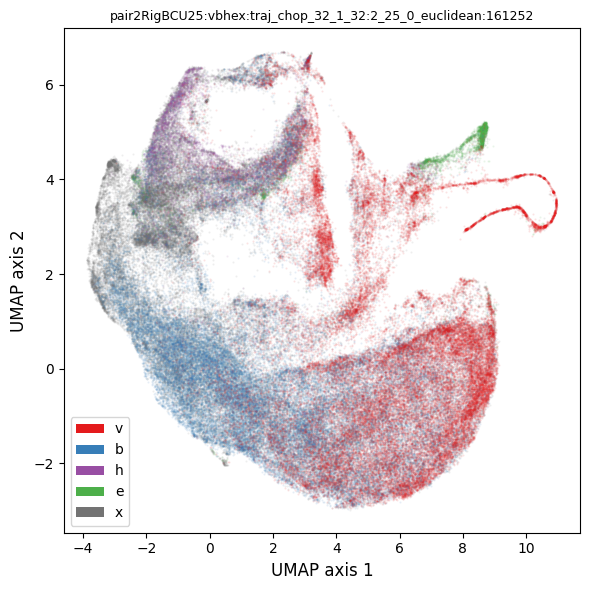

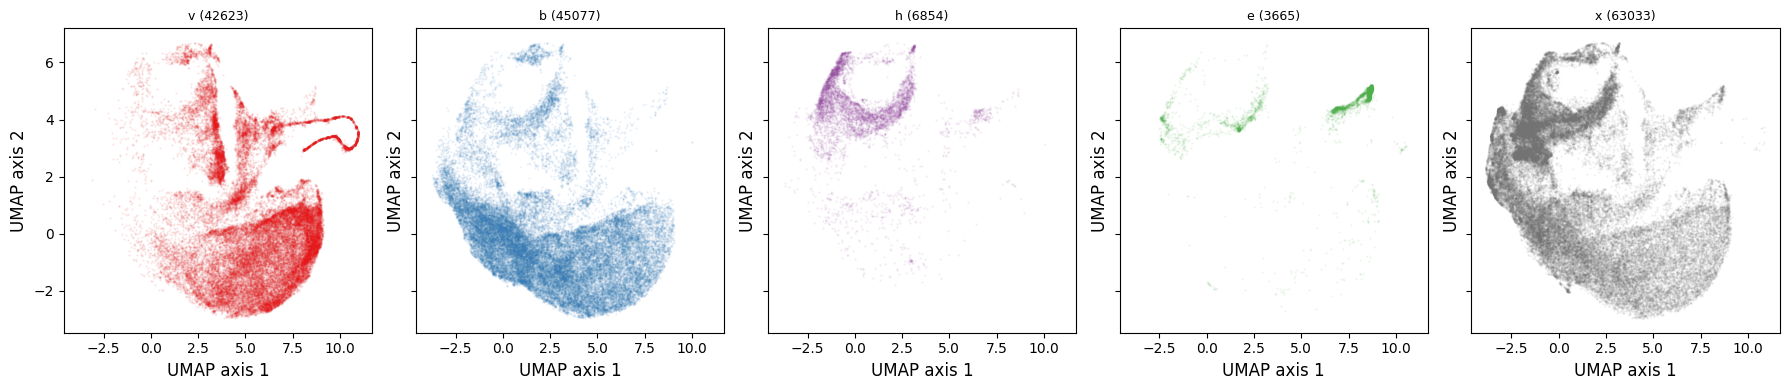

In [8]:
# wi = 0
for wi in range(0, len(win_list)):
    # save in subfolder
    w = win_list[wi]
    rn = f'{w}_1_{w}'
    fd_save = os.path.join(fd_data, bd, 'Traj', umap_suffix, rn)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)
    print(fd_save)

    # load the latent features
    vae_run = f'traj_chop_{rn}'
    fd_vae = os.path.join(fd_data, bd, 'Traj', vae_suffix, vae_run)
    fn_latent_m = os.path.join(fd_vae, 'latentM.csv')
    latent_m = np.loadtxt(fn_latent_m, delimiter=',')
    print(latent_m.shape)

    # also get the meta info about the sliding windows
    chop_run = f'traj_chop_{rn}'
    fd_chop = os.path.join(fd_data, bd, 'Traj', chop_suffix)
    fn_info = os.path.join(fd_chop, f'{bd}.{chop_run}.chop.info.csv')
    info = pd.read_csv(fn_info, index_col=0)
    print(info.shape)
    info.head()

    Counter(info['label'])

    umap_syl = ['v', 'b', 'h', 'e', 'x']
    # umap_syl = ['v']
    # umap_syl = ['v', 'b']
    # umap_syl = ['v', 'b', 'x']
    syl_str = ''.join(umap_syl)

    # select rows that belong to the syllable
    idx_syl = np.array(info[info['label'].isin(umap_syl)].index)
    info_this = info.iloc[idx_syl,:].copy()
    info_this.index = range(info_this.shape[0])
    latent_this = latent_m[idx_syl,:].copy()
    print(info_this.shape, latent_this.shape)

    # run UMAP
    # add latent_m to the embedding data frame
    embed = info_this.copy()
    for ii in range(latent_this.shape[1]):
        embed[f'vae{ii}'] = latent_this[:,ii]

    print(param_umap)
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_this)

    # add UMAP embedding to the dataframe
    for jj in range(res.shape[1]):
        embed[f'umap{jj+1}'] = res[:,jj]

    # save the UMAP model for later usage
    fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.{syl_str}.p')
    pickle.dump(umap_model, open(fn_umap, 'wb'))

    # save the embedding results
    fn_embed = os.path.join(fd_save, f'{bd}.{syl_str}.{vae_run}.embedding.csv')
    embed.to_csv(fn_embed)
    print(fn_embed)

    ## plot embedding
    col_list = ['#e41a1c', '#377eb8', '#984ea3', '#4daf4a', '#737373']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 6])
    # for si, ss in enumerate(syl):
    # plot the X first
    for si in range(len(syl)-1, -1, -1):
        ss = syl[si]
        embed_s = embed[embed['label']==ss]
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.1, c=col_list[si], rasterized=True)
    # add legend
    legends = [Patch(facecolor=col, label=name) for col, name in zip(col_list, syl)]
    plt.legend(handles=legends, loc='lower left')
    ax.set_title(f'{bd}:{syl_str}:{chop_run}:{umap_run}:{embed.shape[0]}', fontsize=9)
    ax.set_xlabel('UMAP axis 1', fontsize=12)
    ax.set_ylabel('UMAP axis 2', fontsize=12)
    plt.tight_layout()
    # save fig
    fn_fig =os.path.join(fd_save, f'{bd}.{syl_str}.embedding.pdf')
    fig.savefig(fn_fig, dpi=600)

    # plot in seperate panels
    col_list = ['#e41a1c', '#377eb8', '#984ea3', '#4daf4a', '#737373']
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[18, 4], sharex=True, sharey=True)
    # for si, ss in enumerate(syl):
    # plot the X first
    for si in range(len(syl)-1, -1, -1):
        ax = axes[si]
        ss = syl[si]
        embed_s = embed[embed['label']==ss]
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.1, c=col_list[si], rasterized=True)
        ax.set_title(f'{ss} ({embed_s.shape[0]})', fontsize=9)
        ax.set_xlabel('UMAP axis 1', fontsize=12)
        ax.set_ylabel('UMAP axis 2', fontsize=12)
    plt.tight_layout()
    # save fig
    fn_fig =os.path.join(fd_save, f'{bd}.{syl_str}.embeddingInd.pdf')
    fig.savefig(fn_fig, dpi=600)
    
    del latent_m, info, embed, res, umap_model
    gc.collect()